# Denoising Shabby Pages

https://www.kaggle.com/competitions/denoising-shabby-pages

https://wandb.ai/dbrambilla13/shabby-pages?workspace=user-dbrambilla13

https://github.com/dbrambilla13/denoising-shabby-pages

In [2]:
import torch
import torchvision

In [3]:
import os
from tqdm import tqdm

# Dataset

In [4]:
from torch.utils.data import Dataset, DataLoader
import json

from torchvision import transforms 
import torchvision.transforms.functional as TF

import random


class ShabbyPagesDataset(Dataset):

    def __init__(self, split="train", augment=False, crop_ratio=0.8, rotation_angle=90, flip_probability=0.5):
        super().__init__()

        self.augment = augment
        self.crop_ratio = crop_ratio
        self.rotation_angle = rotation_angle
        self.flip_probability = flip_probability


        self.folder_shabby = f"{split}/{split}/{split}_shabby/"
        self.folder_clean = f"{split}/{split}/{split}_cleaned/"

        self.image_dict = {}
        for idx, image_name in enumerate(os.listdir(self.folder_shabby)):
            self.image_dict[idx] = image_name

        with open(f"{split}_image_dict.json", "w") as f:
            json.dump(self.image_dict, f)

    def transform(self, input_img, target_img):
        
        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            input_img, output_size=(int(400*self.crop_ratio), int(400*self.crop_ratio)))
        input_img = TF.crop(input_img, i, j, h, w)
        target_img = TF.crop(target_img, i, j, h, w)

        # Random horizontal flipping
        if random.random() < self.flip_probability:
            input_img = TF.hflip(input_img)
            target_img = TF.hflip(target_img)

        # Random vertical flipping
        if random.random() < self.flip_probability:
            input_img = TF.vflip(input_img)
            target_img = TF.vflip(target_img)

        # Random Rotation 
        angle = random.randint(-90,+90)
        input_img = TF.rotate(input_img, angle)
        target_img = TF.rotate(target_img, angle)

        return input_img, target_img

    def __len__(self):
        return len(self.image_dict)

    def __getitem__(self, idx):
        input_sample = (
            torchvision.io.read_image(
                os.path.join(self.folder_shabby, self.image_dict[idx])
            ).to(dtype=torch.float32)
        )/255.0
        target_sample = (
            torchvision.io.read_image(
                os.path.join(self.folder_clean, self.image_dict[idx])
            ).to(dtype=torch.float32)
        )/255.0

        if self.augment:
            return self.transform(input_sample,target_sample)
        else:
            return input_sample, target_sample

In [5]:
train_dataset = ShabbyPagesDataset(split="train", augment=True)
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=16, shuffle=True, num_workers=8
)

test_dataset = ShabbyPagesDataset(split="test")
test_dataloader = DataLoader(
    dataset=test_dataset, batch_size=16, shuffle=False, num_workers=8
)


validate_dataset = ShabbyPagesDataset(split="validate")
validate_dataloader = DataLoader(
    dataset=validate_dataset, batch_size=16, shuffle=False, num_workers=8
)

# deep learning model

In [6]:
from DenoisingNet import DenoisingNet

model = DenoisingNet()

In [7]:
# model testing

for x,y in train_dataloader:
    model(x)
    break

In [8]:
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import WandbLogger
import lightning


early_stopping = EarlyStopping(
    # monitor='valid_mse',
    monitor="mse_val",
    patience=25,
    mode="min",
)

checkpoint_callback = ModelCheckpoint(
    dirpath="saved_models/",
    monitor="mse_val",
    mode="min",
    filename="{epoch}-{mse_val:.3f}",
    auto_insert_metric_name=True,
)

wandb_logger = WandbLogger(project="shabby-pages")


trainer = lightning.Trainer(
    max_epochs=500,
    # accelerator=device,
    precision="16-mixed",
    logger=wandb_logger,
    callbacks=[early_stopping, checkpoint_callback],
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:


# train model

trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=validate_dataloader)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dbrambilla13. Use `wandb login --relogin` to force relogin


/home/daniele/personal/git/denoising-shabby-pages/.env/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/daniele/personal/git/denoising-shabby-pages/saved_models exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type    | Params
-------------------------------------
0 | cnet     | ConvNet | 1.8 M 
1 | mse_loss | MSELoss | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.386     Total estimated model params size (MB)


Epoch 182: 100%|██████████| 62/62 [00:20<00:00,  3.06it/s, v_num=9k1g, mse_val=0.0179, rmse_val=0.133, mse_train=0.0455]


# Model Evaluation

In [9]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


In [10]:
trained_model = DenoisingNet.load_from_checkpoint('pretty-elevator-27-epoch=236-mse_val=0.017.ckpt').eval().cpu()

In [11]:
trainer.test(
    model=trained_model,
    dataloaders=test_dataloader
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dbrambilla13. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 12/12 [00:01<00:00,  8.21it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        mse_test           0.017391199246048927
        rmse_test           0.13122156262397766
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'mse_test': 0.017391199246048927, 'rmse_test': 0.13122156262397766}]

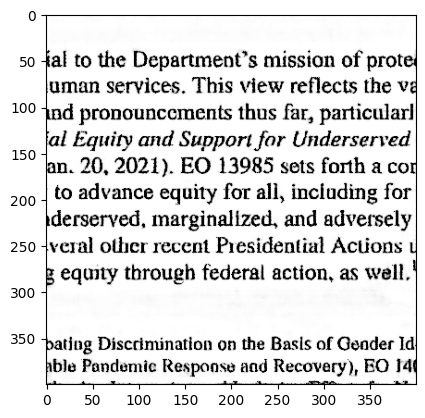

In [12]:


for x, y in test_dataset:
    # print(x.shape)
    # img=x
    # img=y
    img = trained_model(x.detach().cpu().unsqueeze(0))
    # img = y.unsqueeze(0)

    img = F.to_pil_image(img.squeeze(0), mode="L")
    plt.imshow(img, cmap="gray")
    plt.show()
    break

# submission

In [21]:
submission_images_path = 'competition_images/competition_images/'
for file in os.listdir(submission_images_path):
    imgpath = os.path.join(submission_images_path,file)
    print(imgpath)
    x = torchvision.io.read_image(imgpath).to(dtype=torch.float32)/255.0

    y = trained_model(x.unsqueeze(0))
    

    
    cleaned_img = F.to_pil_image(y.squeeze(0))
    cleaned_img.save(f'competition_images/cleaned/{file}_cleaned.png')
    

competition_images/competition_images/0048-Archives-resources_socialmediacapture.pdf-21.png
competition_images/competition_images/0218-irs_pmta00173_6973.pdf-4.png
competition_images/competition_images/0565-IDEA-Politics_Meets_Policies.pdf-080.png
competition_images/competition_images/0154-ECHR_rules_court.pdf-69.png
competition_images/competition_images/0051-INDOJ-THE CONTEMPT OF COURTS ACT 1971.pdf-6.png
competition_images/competition_images/0419-WarwickSchools_School-Plan-2021-2022.pdf-04.png
competition_images/competition_images/0424-SupremeCourt-opinions_21a23_ap6c.pdf-09.png
competition_images/competition_images/0358-PerfectEnglishGrammar_tenses-infographics.pdf-05.png
competition_images/competition_images/0183-kidzcare_Patient-Registration-Packet-2019.pdf-1.png
competition_images/competition_images/0115-FSU-islandora-shock_therapy.pdf-084.png
competition_images/competition_images/0572-Earthday-trees.pdf-2.png
competition_images/competition_images/0502-CEJSH_Ostromecka.pdf-1.png
